## Import and data load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree
import pydot_ng as pdot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
import itertools

In [2]:
df = pd.read_csv("/home/data/MSA8010/msa8010f16t10/projectdata_new.csv")

In [3]:
df.drop(['loan_amnt (optional)', 'installment (optional)','annual_inc (optional)',
         'dti (optional)', 'dti2 (optional)','addr_state'], axis=1, inplace=True)
df.dropna(inplace=True)

## Define features and create feature matrices

In [4]:
all_features = set(df.columns)-set(['loan_status'])
num_features = set(df.describe().columns)
cat_features = all_features-num_features
print("All features:         ", ", ".join(all_features), "\nNumerical features:   ", ", ".join(num_features), "\nCategorical features: ", ", ".join(cat_features))

All features:          open_acc, Credit History (year), verification_status, home_ownership, inq_last_6mths, term, total_dti, revol_util, revol_bal, int_rate, pub_rec, purpose, total_acc, emp_length, delinq_2yrs, grade 
Numerical features:    loan_status, open_acc, Credit History (year), inq_last_6mths, revol_bal, int_rate, pub_rec, total_dti, total_acc, revol_util, delinq_2yrs 
Categorical features:  verification_status, home_ownership, purpose, term, emp_length, grade


In [5]:
### convert to categorical variables to numeric ones
level_substitution = {}

def levels2index(levels):
    dct = {}
    for i in range(len(levels)):
        dct[levels[i]] = i
    return dct

df_num = df.copy()

for c in cat_features:
    level_substitution[c] = levels2index(df[c].unique())
    df_num[c].replace(level_substitution[c], inplace=True)

In [6]:
X = df_num.drop("loan_status",axis=1).as_matrix()
y = df_num.loan_status.as_matrix()

## Split and train

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=13)

#### Baseline model

In [8]:
clf = RandomForestClassifier(n_estimators=25, max_depth=None, min_samples_split=5, random_state=13, max_features='sqrt')
clf.fit(X_train, y_train)
ŷ = clf.predict(X_test)
print(classification_report(y_test, ŷ))

             precision    recall  f1-score   support

          0       0.82      0.98      0.90     83030
          1       0.43      0.07      0.11     18566

avg / total       0.75      0.81      0.75    101596



## Iterations

In [9]:
performance_template_df = pd.DataFrame(columns= [
        ['Params']*2 + [b for a in ['Precision', 'Recall', 'F1_score', 'Support'] for b in [a, a]],
        ['N Trees', 'Max Features'] + ['no', 'yes']*4
    ])
performance_template_df

Empty DataFrame
Columns: [(Params, N Trees), (Params, Max Features), (Precision, no), (Precision, yes), (Recall, no), (Recall, yes), (F1_score, no), (F1_score, yes), (Support, no), (Support, yes)]
Index: []

In [10]:
%%time
performance_df = performance_template_df.copy() #-- always start fresh


for ntree in [10,20,40,60,100,150]:
    for maxfeat in [2,4,6,8,12,16]:
        clf1 = RandomForestClassifier(n_estimators=ntree, 
                                      max_features=maxfeat, 
                                      min_samples_split=50,
                                      max_depth=10,
                                      n_jobs=-1, 
                                      random_state=13, 
                                      class_weight='balanced')
        clf1.fit(X_train, y_train)
        ŷ1 = clf1.predict(X_test)
        perf_arr = None    #-- this array will hold results for different random samples
        prf1s = precision_recall_fscore_support(y_test, ŷ1)
        if type(perf_arr)!=type(None):
            perf_arr = np.vstack((perf, np.array(prf1s).reshape(1,8)))
        else:
            perf_arr = np.array(prf1s).reshape(1,8)
        perf_df = pd.concat([pd.DataFrame({'a': [ntree], 'b': [maxfeat]}),
                            pd.DataFrame(perf_arr.reshape(1, 8))], axis=1, ignore_index=True)
        perf_df.columns=performance_df.columns
        performance_df = performance_df.append(perf_df, ignore_index=True)

CPU times: user 30min 17s, sys: 26.6 s, total: 30min 43s
Wall time: 1min 30s


In [11]:
performance_df

Params              Precision              Recall            F1_score  \
   N Trees Max Features        no       yes        no       yes        no   
0     10.0          2.0  0.884138  0.290265  0.666964  0.609124  0.760347   
1     10.0          4.0  0.884140  0.290774  0.668168  0.608424  0.761130   
2     10.0          6.0  0.882829  0.292029  0.675142  0.599267  0.765142   
3     10.0          8.0  0.883395  0.292179  0.673744  0.602284  0.764456   
4     10.0         12.0  0.882417  0.294817  0.682765  0.593127  0.769858   
5     10.0         16.0  0.882397  0.293609  0.680104  0.594635  0.768155   
6     20.0          2.0  0.886015  0.289740  0.660002  0.620274  0.756488   
7     20.0          4.0  0.885404  0.291402  0.665808  0.614618  0.760062   
8     20.0          6.0  0.884591  0.293986  0.674262  0.606593  0.765237   
9     20.0          8.0  0.884076  0.292476  0.672347  0.605731  0.763811   
10    20.0         12.0  0.883514  0.294553  0.678815  0.599752  0.767754   
11    20.0         16.0  0.883196  0.293763  0.677996  0.598998  0.767110   
12    40.0          2.0  0.886053  0.290711  0.662218  0.619143  0.757956   
13    40.0          4.0  0.885724  0.291238  0.664459  0.616611  0.759300   
14    40.0          6.0  0.884925  0.294014  0.673323  0.608424  0.764757   
15    40.0          8.0  0.884966  0.293621  0.672299  0.609178  0.764111   
16    40.0         12.0  0.884411  0.295829  0.678971  0.603146  0.768193   
17    40.0         16.0  0.883940  0.294631  0.677695  0.602068  0.767198   
18    60.0          2.0  0.886722  0.290832  0.660508  0.622644  0.757078   
19    60.0          4.0  0.885975  0.292257  0.666109  0.616611  0.760469   
20    60.0          6.0  0.885728  0.294789  0.672697  0.611871  0.764652   
21    60.0          8.0  0.885166  0.294870  0.674551  0.608639  0.765639   
22    60.0         12.0  0.884252  0.295680  0.679116  0.602445  0.768226   
23    60.0         16.0  0.884056  0.295740  0.679839  0.601260  0.768614   
24   100.0          2.0  0.886530  0.290774  0.660942  0.621674  0.757293   
25   100.0          4.0  0.886144  0.291749  0.664410  0.618227  0.759423   
26   100.0          6.0  0.885834  0.294620  0.671998  0.612679  0.764240   
27   100.0          8.0  0.885174  0.295274  0.675443  0.608155  0.766216   
28   100.0         12.0  0.884920  0.296165  0.678201  0.605569  0.767891   
29   100.0         16.0  0.884016  0.295240  0.678839  0.601691  0.767959   
30   150.0          2.0  0.886362  0.290771  0.661436  0.620758  0.757556   
31   150.0          4.0  0.886222  0.292069  0.664928  0.618227  0.759790   
32   150.0          6.0  0.886003  0.294513  0.671251  0.613756  0.763820   
33   150.0          8.0  0.885251  0.295643  0.676045  0.608101  0.766632   
34   150.0         12.0  0.885015  0.296535  0.678743  0.605623  0.768274   
35   150.0         16.0  0.884299  0.295884  0.679429  0.602445  0.768444   

              Support           
         yes       no      yes  
0   0.393172  83030.0  18566.0  
1   0.393493  83030.0  18566.0  
2   0.392694  83030.0  18566.0  
3   0.393476  83030.0  18566.0  
4   0.393862  83030.0  18566.0  
5   0.393113  83030.0  18566.0  
6   0.394979  83030.0  18566.0  
7   0.395357  83030.0  18566.0  
8   0.396033  83030.0  18566.0  
9   0.394479  83030.0  18566.0  
10  0.395075  83030.0  18566.0  
11  0.394201  83030.0  18566.0  
12  0.395649  83030.0  18566.0  
13  0.395618  83030.0  18566.0  
14  0.396448  83030.0  18566.0  
15  0.396251  83030.0  18566.0  
16  0.396958  83030.0  18566.0  
17  0.395646  83030.0  18566.0  
18  0.396474  83030.0  18566.0  
19  0.396557  83030.0  18566.0  
20  0.397884  83030.0  18566.0  
21  0.397272  83030.0  18566.0  
22  0.396673  83030.0  18566.0  
23  0.396470  83030.0  18566.0  
24  0.396224  83030.0  18566.0  
25  0.396422  83030.0  18566.0  
26  0.397901  83030.0  18566.0  
27  0.397535  83030.0  18566.0  
28  0.397785  83030.0  18566.0  
29  0.396114  83030.0  18566.0  
30  0.396035  83030.0

In [12]:
best = performance_df.F1_score.yes.argmax()
print(performance_df.iloc[best])

Params     N Trees           150.000000
           Max Features       12.000000
Precision  no                  0.885015
           yes                 0.296535
Recall     no                  0.678743
           yes                 0.605623
F1_score   no                  0.768274
           yes                 0.398130
Support    no              83030.000000
           yes             18566.000000
Name: 34, dtype: float64


### Best model

In [21]:
clf2 = RandomForestClassifier(n_estimators=150, 
                                      max_features=12, 
                                      min_samples_split=50,
                                      max_depth=10,
                                      n_jobs=-1, 
                                      random_state=13, 
                                      class_weight='balanced')
clf2.fit(X_train, y_train)
ŷ2 = clf2.predict(X_test)
print(classification_report(y_test, ŷ2))

             precision    recall  f1-score   support

          0       0.89      0.68      0.77     83030
          1       0.30      0.61      0.40     18566

avg / total       0.78      0.67      0.70    101596



In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
cnf_matrix = confusion_matrix(y_test, ŷ2)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[56356 26674]
 [ 7322 11244]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.39  0.61]]


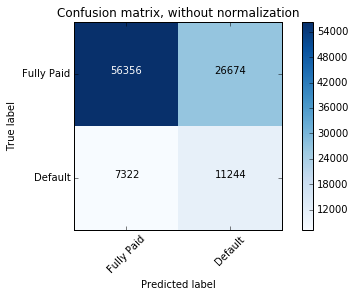

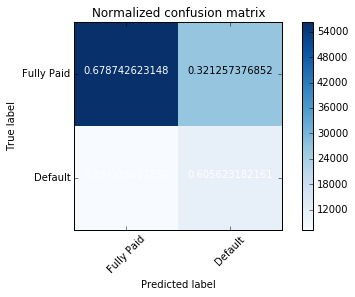

In [24]:
class_names = ['Fully Paid','Default']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
None